## **Reinforcement Learning**
###comparing REINFORCE algorithm and Actor-critic method for cartepole balance

Farzaneh Entezari - email: farzaneh.entezari@mail.mcgill.ca

 

In [ ]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from tqdm import tqdm_notebook as tqdm
import random

In [ ]:
class Policy_MLP(nn.Module):  # defining a 2 layer MLP as policy
  def __init__(self, alpha , observation_space , hidden_dim , action_space):
    super().__init__()
    self.alpha = alpha
    self.observation_space = observation_space
    self.hidden_dim = hidden_dim
    self.action_space = action_space
    self.fcn1 = nn.Linear(self.observation_space , self.hidden_dim)
    self.fcn2 = nn.Linear(self.hidden_dim , self.action_space)
    self.optimizer = optim.Adam(self.parameters() , lr=self.alpha)

    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')
    self.to(self.device)

  def forward(self, state): 
    state = T.Tensor(state).to(self.device)
    x= self.fcn1(state)
    x= F.relu(x)
    x= self.fcn2(x)
    return x  # returns a tensor of dim 2 



In [ ]:
class ValueFunc_MLP(nn.Module):  # approximating value function as a 2 layer MLP
  def __init__(self, beta , observation_space , hidden_dim):
    super().__init__()
    self.beta = beta
    self.observation_space = observation_space
    self.hidden_dim = hidden_dim
    self.fcn1 = nn.Linear(self.observation_space , self.hidden_dim)
    self.fcn2 = nn.Linear(self.hidden_dim , 1)
    self.optimizer = optim.Adam(self.parameters() , lr=self.beta)

    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')
    self.to(self.device)

  def forward(self, state):
    state = T.Tensor(state).to(self.device)
    x= self.fcn1(state)
    x= F.relu(x)
    x= self.fcn2(x)
    return x #.item()

In [ ]:
class Agent(object):
  def __init__(self, alpha , beta , observation_space , action_space, hidden_dim, gamma=0.9):  ## hidden dim for both networks(policy and value) are assumed equal
    self.gamma = gamma
    self.alpha = alpha
    self.beta = beta
    self.observation_space = observation_space
    self.hidden_dim = hidden_dim
    self.action_space = action_space
    # store s a r during each episode
    self.all_rewards= []
    self.all_actions= []
    self.all_values= []
    self.returns = []
    #define policy network and value function network
    self.policy = Policy_MLP(self.alpha , self.observation_space , self.hidden_dim, self.action_space)
    self.valuefunc = ValueFunc_MLP(self.beta , self.observation_space , self.hidden_dim)

  def reset(self):
    self.clear_memory() ## resets episodes history
    self.policy = Policy_MLP(self.alpha , self.observation_space , self.hidden_dim, self.action_space)  ## resets the policy at the start point of each run
    self.valuefunc = ValueFunc_MLP(self.beta , self.observation_space , self.hidden_dim) ## resets the value func approximator at the start point of each run
    
  def choose_action(self,state):
    p = F.softmax(self.policy.forward(state),dim=0)
    probs = T.distributions.Categorical(p) # create a categorical distribution over the list of probabilities of actions 
    action = probs.sample()
    log_probs = probs.log_prob(action)
    self.all_actions.append(log_probs) # stores log policy(state, action)
    return action.item()

  def store_rewards(self,reward):
    self.all_rewards.append(reward) # stores the history of rewards during an episode

  def store_values(self,value):
    self.all_values.append(value) # stores the history of state values during an episode


  def learn_REINFORCE(self): ## calculates REINFORCE loss and performs backprop 
    self.policy.optimizer.zero_grad()
    G= T.tensor(self.returns, dtype=T.float).to(self.policy.device)

    loss = 0
    for g, logprob in zip(G , self.all_actions):
      loss += -g * logprob  ## loss is the negative of objective function J

    loss.backward()
    self.policy.optimizer.step()

  def clear_memory(self): ## reset history after each episode
    self.all_actions = []
    self.all_rewards = []
    self.all_values = []
    self.returns = []

  def store_returns(self): ## computes discounted return form each stete action pair in the episode
    G = np.zeros_like(self.all_rewards , dtype=np.float64)
    for t in range(len(self.all_rewards)):
      G_sum = 0
      discount = 1
      for k in range(t, len(self.all_rewards)):
        G_sum += self.all_rewards[k] * discount
        discount *= self.gamma
      G[t] = G_sum
    
    mean = np.mean(G)
    std = np.std(G) if np.std(G) > 0 else 1
    G = (G-mean) / std
    self.returns = G ## stores the true values during the episode

  def learn_Actor(self): ## calculates policy gradient loss and performs backprop
    self.policy.optimizer.zero_grad() # reset gradients

    loss =0
    for g, value, logprob in zip(self.returns ,self.all_values , self.all_actions):
      advantage = g - value 
      loss += - advantage * logprob  ## loss defined as the negative of objective function J

    loss.backward(retain_graph=True)
    self.policy.optimizer.step()

  def learn_Critic(self): ## calculates value function loss and performs backprop
    self.valuefunc.optimizer.zero_grad()
    G= T.tensor(self.returns, dtype=T.float).to(self.policy.device)
    #agent.valuefunc.init_hidden() 
    
    loss = 0
    for g, value in zip(G ,self.all_values):
      #loss += F.smooth_l1_loss(g , value)
      loss += (g - value) ** 2 # loss defined as sum of square error # Compatible FA Theorem 

    loss.backward(retain_graph=True)
    self.policy.optimizer.step()


## Build the environment


In [ ]:
env= gym.make("CartPole-v0")
env.reset()
observation_space = env.observation_space.shape[0] ## state dimension = 4
action_space = env.action_space.n  ## 2 actions (0 or 1)
# build the agent, set the learning rates and hidden layer dimension
agent = Agent(alpha=0.001, beta = 0.001, observation_space=observation_space, action_space=action_space , hidden_dim=128)

## Monte_Carlo Policy Gradient (REINFORCE) algorithm

In [ ]:
env.reset()
agent.reset()


all_cum_reward=[]
n_episodes = 500
n_runs = 5

seeds = [random.randint(0, 10) for iter in range(5)]


with tqdm(total= n_runs * n_episodes) as pbar:
  for j in range(n_runs):
    env.seed(seeds[j])
    agent.reset() ## resets learnt networks
    epis_cum_reward=[]
    cum_reward = 0
    for i in range(n_episodes):
      done = False
      cum_reward = 0 
      state = env.reset()

      while (not done):  ## run an episode until termination 
                         # an episode terminates when the pendulum falls off or num of steps exceeds 200
        action = agent.choose_action(state)  ## selects action with policy network
        next_s , reward, done , info = env.step(action)  ## takes action and observes next state and reward from environment
        agent.store_rewards(reward)
        state = next_s
        cum_reward += reward

      epis_cum_reward.append(cum_reward)
      agent.store_returns()
      agent.learn_REINFORCE()  ## performs backprop and updates policy network parameters
      agent.clear_memory()
      
      pbar.update(1)
    
    all_cum_reward.append(epis_cum_reward)

scores_REINFORCE = all_cum_reward

Text(0.5, 0.98, 'Results of performing Monte_carlo policy gradient algorithm on gym cartpole environment averaged over 5 seeds.')

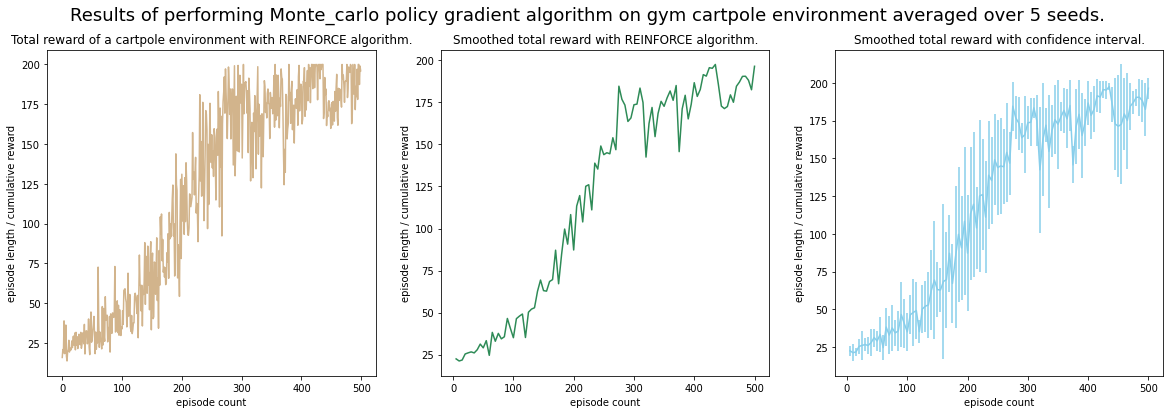

In [ ]:
f, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20,6))

ax1.plot(np.mean(scores_REINFORCE,axis=0) , 'tan')
ax1.set_title('Total reward of a cartpole environment with REINFORCE algorithm.')
ax1.set_xlabel("episode count")
ax1.set_ylabel("episode length / cumulative reward")

scores_REINFORCE = np.atleast_2d(scores_REINFORCE)
scores_REINFORCE_smooth = np.mean(scores_REINFORCE.reshape(n_runs,-1,5) ,axis=2 ) 
ax2.plot(np.arange(5,n_episodes+1,5), np.mean ( scores_REINFORCE_smooth , axis=0) , 'seagreen' )
ax2.set_title('Smoothed total reward with REINFORCE algorithm.')
ax2.set_xlabel("episode count")
ax2.set_ylabel("episode length / cumulative reward")

ax3.errorbar(x= np.arange(5,n_episodes+1,5), y = np.mean(scores_REINFORCE_smooth , axis=0) , yerr = np.std(scores_REINFORCE_smooth , axis=0)  , color = 'skyblue')
ax3.set_title('Smoothed total reward with confidence interval.')
ax3.set_xlabel("episode count")
ax3.set_ylabel("episode length / cumulative reward")

f.suptitle('Results of performing Monte_carlo policy gradient algorithm on gym cartpole environment averaged over 5 seeds.', fontsize=18)



Total rewards are averaged over 5 different runs. I plotted a smopthed version of total reward with standard deviation to better see the confidence interval.

## Advantage Actor_Critic (A2C) algorithm

In [ ]:
env.reset()
agent.reset()


all_cum_reward=[]
n_episodes = 500
n_runs = 5

seeds = [random.randint(0, 10) for iter in range(5)]

with tqdm(total= n_runs * n_episodes) as pbar:
  for j in range(n_runs):
    env.seed(seeds[j])
    agent.reset()
    epis_cum_reward=[]
    cum_reward = 0
    for i in range(n_episodes):
      done = False
      cum_reward = 0 
      state = env.reset()

      while (not done):
        action = agent.choose_action(state)
        next_s , reward, done , info = env.step(action)
        agent.store_rewards(reward)
        agent.store_values( agent.valuefunc.forward(state) ) ## stores state values 
        state = next_s
        cum_reward += reward

      epis_cum_reward.append(cum_reward)
      agent.store_returns()
      agent.learn_Critic() ## performs backprop and updates value function network parameters
      agent.learn_Actor()  ## performs backprop and updates policy network parameters
      agent.clear_memory()
      pbar.update(1)
    
    all_cum_reward.append(epis_cum_reward)

scores_A2C = all_cum_reward

Text(0.5, 0.98, 'Results of performing A2C policy gradient algorithm on gym cartpole environment averaged over 5 seeds.')

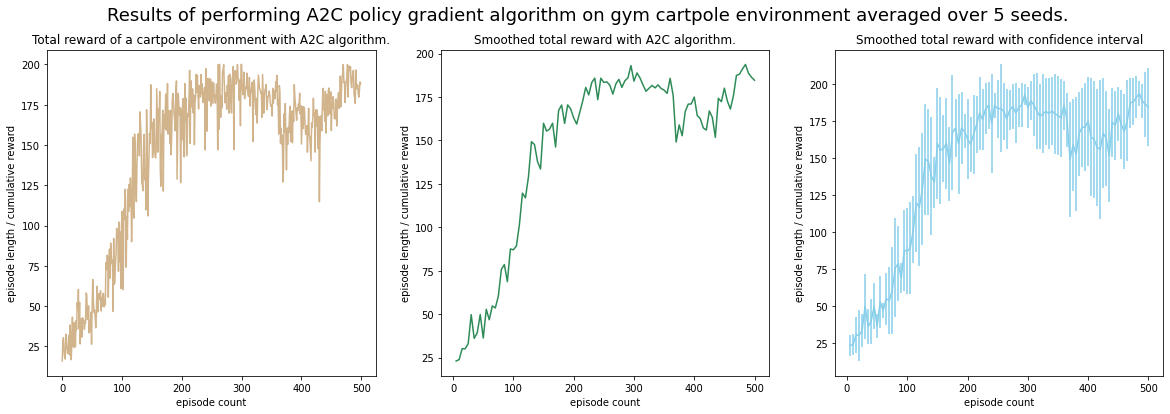

In [ ]:
f, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20,6))

ax1.plot(np.mean(scores_A2C,axis=0) , 'tan')
ax1.set_title('Total reward of a cartpole environment with A2C algorithm.')
ax1.set_xlabel("episode count")
ax1.set_ylabel("episode length / cumulative reward")

scores_A2C = np.atleast_2d(scores_A2C)
scores_A2C_smoooth = np.mean(scores_A2C.reshape(n_runs,-1,5) ,axis=2 ) 
ax2.plot(np.arange(5,n_episodes+1,5) ,np.mean ( scores_A2C_smoooth , axis=0)  , 'seagreen')
ax2.set_title('Smoothed total reward with A2C algorithm.')
ax2.set_xlabel("episode count")
ax2.set_ylabel("episode length / cumulative reward")

ax3.errorbar(x= np.arange(5,n_episodes+1,5) , y = np.mean(scores_A2C_smoooth , axis=0) , yerr = np.std(scores_A2C_smoooth , axis=0) , color = 'skyblue')
ax3.set_title('Smoothed total reward with confidence interval')
ax3.set_xlabel("episode count")
ax3.set_ylabel("episode length / cumulative reward")

f.suptitle('Results of performing A2C policy gradient algorithm on gym cartpole environment averaged over 5 seeds.', fontsize=18)


Total rewards are averaged over 5 different runs. I plotted a smopthed version of total reward with standard deviation to better see the confidence interval.

## Comparison

Text(0, 0.5, 'episode length / cumulative reward')

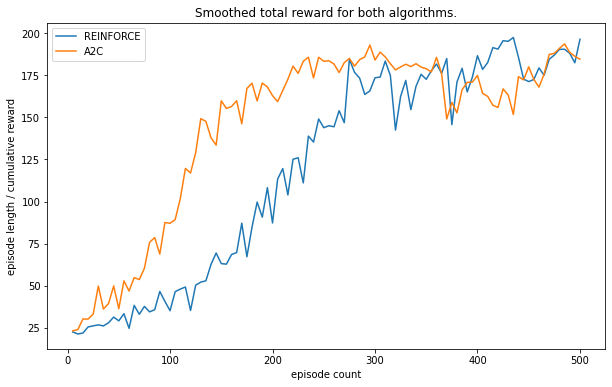

In [ ]:
plt.figure(num=1, figsize=(10, 6))
plt.plot(np.arange(5,n_episodes+1,5) , np.mean ( scores_REINFORCE_smooth , axis=0)  , label='REINFORCE')
plt.plot(np.arange(5,n_episodes+1,5) , np.mean ( scores_A2C_smoooth , axis=0) , label='A2C'  )
plt.legend(loc="upper left")
plt.title('Smoothed total reward for both algorithms.')
plt.xlabel("episode count")
plt.ylabel("episode length / cumulative reward")

## Observations

Both REINFORCE and Actor Critic algorithms succeeded to converge. However, they are different in stability and speed of convergence.

In reinforce algorithm the agent takes a lot of actions over the course of an episode so it’s hard to assign credit to the right action. This high variability in log probabilities and cumulative reward values leads to higher variance in updates for reinforce methode.

However in actor critic algorithm, we bootstrap predictions of value function for each step. Subtracting the baseline term $v(s)$ from policy gradient makes it have lower variance in comparison with reinforce algorithm.

Another difference is the fact that actor critic converges to the optimal parameters much faster than reinforce algorithm. That's because we are updating parameters in actor critic algorithm online while we need to wait until the end of an episode for a update in reinforce algorithm.
